## 도서관데이터활용 공모전 전체 코드 

### 데이터 관리

In [324]:
import pandas as pd

# 도서관 정보나루 7월 인기대출도서 상위 5권(장르 및 null 값 전처리 적용)
popular_loan_book= pd.read_csv("C:/Users/user/Desktop/library/popular_loan_book.csv",encoding= 'CP949') 

# 인디펍 플랫폼 독립서적 2085건
indi_book = pd.read_csv("C:/Users/user/Desktop/library/indi_book.csv") 
indi_book = indi_book.drop("Unnamed: 0", axis =1)


### 데이터 전처리 

In [325]:
print(f"가져온 인디펍 플랫폼 독립서적 개수: {len(indi_book)}")

# 빈 feature 값이 존재하는 데이터 삭제 
indi_book = indi_book.dropna()

print(f"sparse한 데이터 삭제 후 인디펍 플랫폼 독립서적 개수: {len(indi_book)}")

가져온 인디펍 플랫폼 독립서적 개수: 2085
sparse한 데이터 삭제 후 인디펍 플랫폼 독립서적 개수: 1598


In [326]:
# 인디펍 플랫폼 독립서적 장르 표준화
print("인디펍 플랫폼 독립서적 장르")
print("\n")
print(indi_book["장르"].drop_duplicates())

print("\n")
# 문학>한국문학>시 등 표준화가 되어있지 않기에 가장 마지막 > 뒤 장르로 변경 
import re

for index, genre in enumerate(indi_book["장르"]):
    match = re.search(r'>([^>]+)$', genre)
    if match:
        result = match.group(1)
        indi_book.iloc[index,2] =  result
    else:
        indi_book.iloc[index,2] =  genre

print("\n")
print("장르 전처리 후 인디펍 플랫폼 독립서적 장르")
print("\n")
print(indi_book["장르"].drop_duplicates())

인디펍 플랫폼 독립서적 장르


0                                                  시
1                                                 동화
4                                                에세이
5                                                매거진
6                                                 소설
                            ...                     
2027                                           자전적소설
2035                                       에세이>한국에세이
2036    예술/대중문화> 예술일반 예술이야기\n\n      가정/육아>자녀교육>놀이교육
2038                                       문학>한국문학>시
2041                                       여행에세이(남미)
Name: 장르, Length: 152, dtype: object




장르 전처리 후 인디펍 플랫폼 독립서적 장르


0                시
1               동화
4              에세이
5              매거진
6               소설
           ...    
2009    에세이, 시, 소설
2017           산문집
2027         자전적소설
2036          놀이교육
2041     여행에세이(남미)
Name: 장르, Length: 150, dtype: object


In [327]:
# 인디펍 플랫폼 독립서적 중 만화 및 동화, 그림 장르 제외    

print(f"만화 및 동화 장르 제거 전 인디펍 플랫폼 독립서적 개수: {len(indi_book)}")
indi_book = indi_book.loc[~((indi_book["장르"].str.contains("만화")) | (indi_book["장르"].str.contains("동화"))  | (indi_book["장르"].str.contains("일러스트") | (indi_book["장르"].str.contains("사진집"))))]
print(f"만화 및 동화 장르 제거 후 인디펍 플랫폼 독립서적 개수: {len(indi_book)}")

만화 및 동화 장르 제거 전 인디펍 플랫폼 독립서적 개수: 1598
만화 및 동화 장르 제거 후 인디펍 플랫폼 독립서적 개수: 1410


In [328]:
# 인덱스 초기화 

popular_loan_book = popular_loan_book.reset_index()
popular_loan_book = popular_loan_book.drop("index",axis=1)

indi_book = indi_book.reset_index()
indi_book = indi_book.drop("index",axis=1)

### document 생성 

In [329]:
# 도서관 정보나루 7월 인기대출도서 문자열
popular_loan_book_document = popular_loan_book["추천사"] + popular_loan_book["책 속으로"] + popular_loan_book["서평"]

# 인디펍 플랫폼 독립서적 문자열
indi_book_document = indi_book["작가 소개"] + indi_book["줄거리"] + indi_book["책 속으로"]

In [330]:
from konlpy.tag import Okt
import tqdm
okt = Okt()

# 도서관 정보나루 7월 인기대출도서에서 명사만 추출해낸 document
popular_loan_book_document_lst = [] 
for documnet in tqdm.tqdm(popular_loan_book_document):
    popular_loan_book_document_lst.append(okt.nouns(documnet))

# 인디펍 플랫폼 독립서적에서 명사만 추출해낸 documnet 
indi_book_document_lst = [] 
for documnet in tqdm.tqdm(indi_book_document):
    indi_book_document_lst.append(okt.nouns(documnet))

100%|██████████| 1410/1410 [00:50<00:00, 27.81it/s]


In [331]:
# 불용어 제거 작업(한글자 단어 제거)
popular_loan_book_document_lst_post = []
for i in range(len(popular_loan_book_document_lst)):
    cleaned_data = [word for word in popular_loan_book_document_lst[i] if len(word) !=1]
    popular_loan_book_document_lst_post.append(cleaned_data)

indi_book_document_lst_post = []
for i in range(len(indi_book_document_lst)):
    cleaned_data = [word for word in indi_book_document_lst[i] if len(word) !=1]
    indi_book_document_lst_post.append(cleaned_data)

### document 토큰화 수행 

In [332]:
!pip install sentencepiece
import sentencepiece as spm


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [333]:
import itertools
import sentencepiece as spm
# 독립 서적 데이터로 subword 사전 생성
indi_book_document_lst_flatten = list(itertools.chain(*indi_book_document_lst_post))
with open('indi_book_document_lst.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(indi_book_document_lst_flatten))

In [334]:
# sentencePiece 모델 사전 사이즈를 2000으로 하여 더 많은 토큰화가 가능하게 함
spm.SentencePieceTrainer.Train('--input=indi_book_document_lst.txt --model_prefix=indi_book_document_lst --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')

In [335]:
# subword 사전 정보 
import csv
vocab_list = pd.read_csv('indi_book_document_lst.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)

In [336]:
sp = spm.SentencePieceProcessor()
vocab_file = "indi_book_document_lst.model"
sp.load(vocab_file)

True

In [337]:
# 도서관 정보나루 7월 인기대출도서 document 토큰화

import tqdm
popular_loan_book_document_vector = []


for sentence in tqdm.tqdm(popular_loan_book_document_lst_post):
  popular_loan_book_document_vector.append(list(itertools.chain(*sp.encode(sentence, out_type=int))))


100%|██████████| 5/5 [00:00<00:00, 50.18it/s]


In [338]:
# 인디펍 플랫폼 독립서적 document 토큰화 

indi_book_document_vector = []
for sentence in tqdm.tqdm(indi_book_document_lst_post):
  indi_book_document_vector.append(list(itertools.chain(*sp.encode(sentence, out_type=int))))

100%|██████████| 1410/1410 [00:01<00:00, 756.30it/s]


In [339]:
# 이달의 추천 키워드 document 토큰화 

keyword_document = "인생 마음 삶 감정 생각 친구 눈물 비" 
key_word_vector = sp.encode(keyword_document, out_type=int)

### document vector 길이가 모두 다름 

In [340]:
print(f"도서관 정보나루 7월 인기대출도서 document 최대 길이: {max(map(len, popular_loan_book_document_vector))}")
print(f"도서관 정보나루 7월 인기대출도서 document 최소 길이: {min(map(len, popular_loan_book_document_vector))}")
print("\n")
print(f"인디펍 플랫폼 독립서적 document 최대 길이: {max(map(len, indi_book_document_vector))}")
print(f"인디펍 플랫폼 독립서적 document 최소 길이: {min(map(len, indi_book_document_vector))}")
print("\n")
print(f"키워드 document 길이: {len(key_word_vector)}")

도서관 정보나루 7월 인기대출도서 document 최대 길이: 1309
도서관 정보나루 7월 인기대출도서 document 최소 길이: 531


인디펍 플랫폼 독립서적 document 최대 길이: 1154
인디펍 플랫폼 독립서적 document 최소 길이: 10


키워드 document 길이: 9


### 평균 vector 길이 이하 독립서적 인덱스를 걸러냄

In [ ]:
few_indi_index = []
indi_index = []
indi_vec_num = [] 

for index,vector in enumerate(indi_book_document_vector):
    indi_index.append(index)
    indi_vec_num.append(len(vector))
    if len(vector) < 209:
        few_indi_index.append(index) 

208.7695035460993


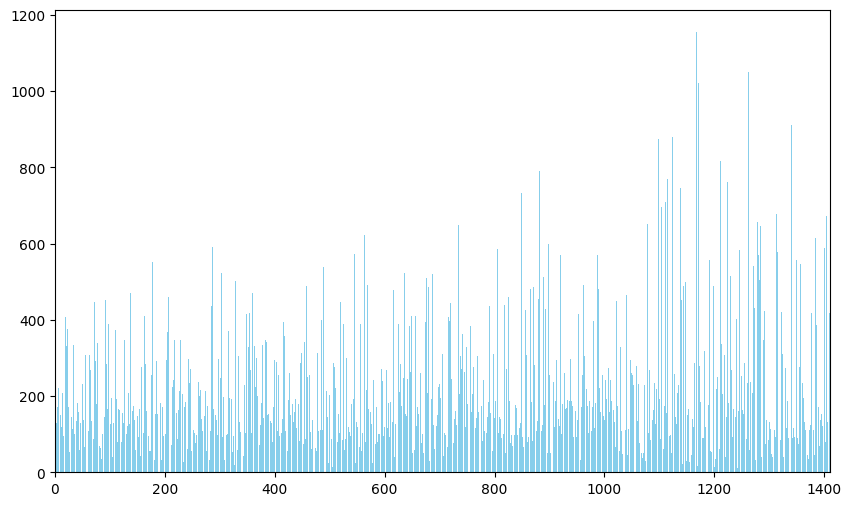

In [469]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.xlim(0, 1410)
plt.bar(indi_index, indi_vec_num , color='skyblue')
print(np.mean(indi_vec_num))


#### 키워드 기반 독립 서적 추천을 위한 유사도로 각 단어의 빈도를 가중치로 하는 Weighted Jaccard similartiy를 사용
#### 인기대출도서와 관련된 top3 독립서적추천을 위해 패딩이 적용된 코사인 유사도를 사용

In [399]:
def Weighted_jaccard_similarity(target_vector, vector):
    # 교집합 계산
    intersection_word_lst = list(set(target_vector).intersection(set(vector)))
    intersection_word_bin = [vector.count(word) for word in intersection_word_lst]

    sum_bin = sum(intersection_word_bin)
    weight_value = [(vector.count(word) / sum_bin) for word in intersection_word_lst]

    intersection = sum(weight_value)
    # 합집합 계산
    union = len(set(target_vector).union(set(vector)))
    # Weighted Jaccard similarity 계산
    return intersection / union

In [400]:
import numpy as np

def pad_vectors(vec1, vec2):
    # 두 벡터의 길이를 비교
    len_diff = len(vec1) - len(vec2)
    
    # vec1이 길면 vec2를 패딩, vec2가 길면 vec1을 패딩
    if len_diff > 0:
        vec2 = np.pad(vec2, (0, len_diff), mode='constant')
    elif len_diff < 0:
        vec1 = np.pad(vec1, (0, -len_diff), mode='constant')
    
    return vec1, vec2

def cosine_similarity(vec1, vec2):
    # 벡터 패딩
    vec1, vec2 = pad_vectors(vec1, vec2)
    
    # 벡터 내적
    dot_product = np.dot(vec1, vec2)
    
    # 벡터의 크기(유클리드 거리)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    
    # 코사인 유사도 계산
    cosine_sim = dot_product / (norm_vec1 * norm_vec2)
    
    return cosine_sim

### 7월 키워드와 유사한 독립서적 필터링(이달의 독립서적)

In [402]:
import numpy as np 
filtering_score = [] 

for index, indi_vector in enumerate(indi_book_document_vector):
    if index not in few_indi_index:
        filtering_score.append(Weighted_jaccard_similarity(key_word_vector, indi_vector))
    else: 
        filtering_score.append(0)
 
# 내림차순으로 top 15개 가져옴 
filtering_index  = np.argsort(filtering_score)[-15:][::-1]
filtering_indi_pool_index = list(filtering_index)
keyword_candidate_indi_book_pool = indi_book.loc[filtering_indi_pool_index]["서명"]

In [406]:
print(f"이달의 독립서적 목록 \n \n {keyword_candidate_indi_book_pool}")

이달의 독립서적 목록 
 
 964                                            SEAGULL
908                               어른이 되었지만 아직 배우는 중입니다
1125                                           러시아 시화집
38                                            당신의 판타지아
1068                                    제주에서 내 식당 창업하기
311                             여성들의 자궁 이야기: 임신 출산은 빼고
1090                                          쓰레기 작업일지
661                                  의사였다가 교수였다가 엄마였다가
209                                      우리들의 혁신학교 이야기
56                                             꽃이 온 마음
21      아, 맞다. 내가 진료 중이었지? (부제 : 어느 어리버리 정신과 의사의 비밀일기)
769          이제는 안 우울합니다만 - 우울증, 폭식증, 무기력증 10년 치료기&극복기
941                                  ULC B: 공공예술로서의 조경
218                                     사라질 것들을 사랑하는 일
1072                                       파도시집선005 우울
Name: 서명, dtype: object


### 도서관 정보나루 7월 인기대출도서와 연관있는 책 추천

In [473]:
top_3 = []
for i in range(len(popular_loan_book_document_vector)):
    similarity_score = [] 
    for j in range(len(indi_book_document_vector)):
        if j not in few_indi_index:
            similarity_score.append(cosine_similarity(np.array(popular_loan_book_document_vector[i]), np.array(indi_book_document_vector[j])))
        else:
            similarity_score.append(-1)
    # 유사도가 높은 순으로 top3 독립서적 추천
    index = np.argsort(similarity_score)[-3:][::-1]
    top_3.append([indi_book.loc[i,"서명"] for i in index ])

In [474]:
for i in range(len(popular_loan_book)):
    print(f"---{popular_loan_book.loc[i,'서명'] }과 연관된 top3 독립서적--- \n \n  {top_3[i]}")
    print("\n")

---불편한 편의점과 연관된 top3 독립서적--- 
 
  ['안녕하새오, 앵무새 치즈애오', '섭주', '목소리 가드닝 - 아름다운 목소리를 위한 보이스 트레이닝']


---지구 끝의 온실과 연관된 top3 독립서적--- 
 
  ['붉은문_조선열녀문답사기(서울,경기편)', '어느 날, 이탈리아 소도시', '파리의 아메리카노']


---밝은 밤 과 연관된 top3 독립서적--- 
 
  ['희망한 적 없는 희망퇴직', '살자편지', '광주 근현대미술의 주요 지점들']


---아주 희미한 빛으로도과 연관된 top3 독립서적--- 
 
  ['기억의 저편', '희망한 적 없는 희망퇴직', '읽을지도, 그러다 떠날지도']


---천 개의 파랑 과 연관된 top3 독립서적--- 
 
  ['부산 공공예술 탐구', '살자편지', '기억의 저편']


